In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8,5.5)

In [2]:
df = pd.read_csv('StudentsPerformance.csv')
df.columns = ['cinsiyet', 'koken', 'aile_egt_seviyesi', 'ogle_yemegi', 
                              'hazirlik_kursu', 'matematik_notu', 'okuma_notu', 'yazma_notu']
df.head()

,cinsiyet,koken,aile_egt_seviyesi,ogle_yemegi,hazirlik_kursu,matematik_notu,okuma_notu,yazma_notu
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


1. Sınav performanslarının nelerle ilişkili olduğunu görmek için bir korelasyon matrisi üretelim.

In [3]:
df.corr()

,matematik_notu,okuma_notu,yazma_notu
matematik_notu,1.000,0.818,0.803
okuma_notu,0.818,1.000,0.955
yazma_notu,0.803,0.955,1.000


In [4]:
df.groupby('cinsiyet').mean()

,matematik_notu,okuma_notu,yazma_notu
cinsiyet,,,
female,63.633,72.608,72.467
male,68.728,65.473,63.311


In [5]:
df.groupby('koken').mean()

,matematik_notu,okuma_notu,yazma_notu
koken,,,
group A,61.629,64.674,62.674
group B,63.453,67.353,65.600
group C,64.464,69.103,67.828
group D,67.363,70.031,70.145
group E,73.821,73.029,71.407


In [6]:
df.groupby('aile_egt_seviyesi').mean()

,matematik_notu,okuma_notu,yazma_notu
aile_egt_seviyesi,,,
associate's degree,67.883,70.928,69.896
bachelor's degree,69.390,73.000,73.381
high school,62.138,64.704,62.449
master's degree,69.746,75.373,75.678
some college,67.128,69.460,68.841
some high school,63.497,66.939,64.888


In [7]:
baslik_font = {'family': 'arial', 'color': 'darkred', 'weight': 'bold', 'size' : 13}
eksen_font = {'family':'arial', 'color':'darkblue', 'weight' : 'bold', 'size':10}

Barplotlar ile bu ilişkilere tekrar bakalım. Cinsiyet, köken ve aile eğitim seviyesinin matematik notlarına etkisini değerlendirelim.

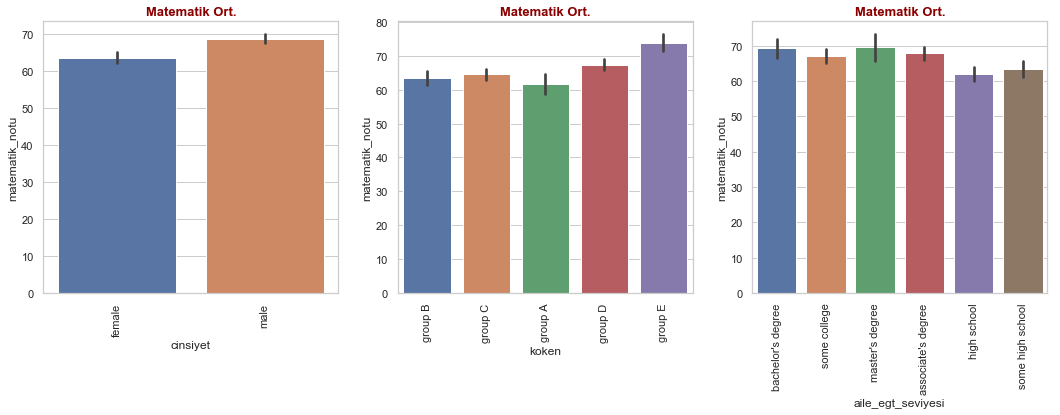

In [8]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.barplot(df["cinsiyet"], df["matematik_notu"])
plt.title("Matematik Ort.", fontdict = baslik_font)
plt.xticks(rotation='vertical')

plt.subplot(1,3,2)
sns.barplot(df["koken"], df["matematik_notu"])
plt.title("Matematik Ort.", fontdict = baslik_font)
plt.xticks(rotation='vertical')

plt.subplot(1,3,3)
sns.barplot(df["aile_egt_seviyesi"], df["matematik_notu"])
plt.title("Matematik Ort.", fontdict = baslik_font)
plt.xticks(rotation='vertical')
plt.show()

Burada kategorik değişkenlerimiz ile sürekli değişkenlerimiz arasında bir ilişki olduğunu gözlemliyoruz. Kaba bir gözlemle aile eğitim seviyesi arttıkça not ortalaması artıyor veya erkekler kızlardan daha başarılı diyebiliriz. 

Ancak dikkat etmemiz gereken nokta, popülasyonu düşük grupların istatistiksel sonuçları yanıltıcı olabilir.

In [9]:
# Erkek ve kız sayıları yakın olduğu için problem yok.
print('erkek sayısı:',df[df['cinsiyet'] == 'male']['cinsiyet'].count())
print('kız sayısı:',df[df['cinsiyet'] == 'female']['cinsiyet'].count())

erkek sayısı: 482
kız sayısı: 518


Matematik notları için farklı kökenden gelen öğrenci sayılarına bakalım.

In [10]:
df.groupby('koken')['matematik_notu'].count()

koken
group A     89
group B    190
group C    319
group D    262
group E    140
Name: matematik_notu, dtype: int64

A grubundaki öğrenci sayısı azlığı yanıltıcı olabilir. Aykırı değer var mı diye bakalım. Varsa temizleyelim.

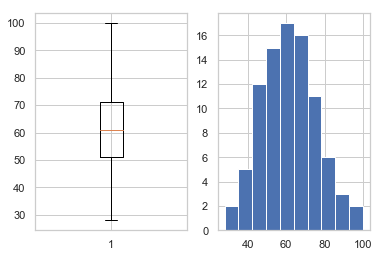

In [11]:
plt.subplot(1,2,1)
plt.boxplot(df[df['koken']== 'group A']['matematik_notu'])

plt.subplot(1,2,2)
plt.hist(df[df['koken']== 'group A']['matematik_notu'])
plt.show()

Boxplot ile baktığımızda aykırı değer görmüyoruz. Aynı şekilde histogram da aşırı değerlere işaret etmiyor. Dolayısıyla aykırı değerleri azaltmak için bir işlem yapmayacağız.

2. Öğle yemek tipinin sınav performanslarıyla ilişkisini inceleyelim.

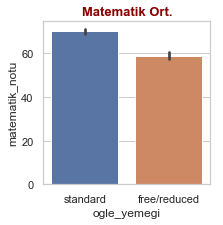

In [12]:
plt.figure(figsize=(3,3))
sns.barplot(df["ogle_yemegi"], df["matematik_notu"])
plt.title("Matematik Ort.", fontdict = baslik_font)
plt.xticks(rotation='horizontal')
plt.show()

In [13]:
# Yemek çeşitleri ve matematik ortalamaları

print('standart yemek mat. ort.', df[df['ogle_yemegi']=='standard']['matematik_notu'].mean())
print('free/reduced yemek mat. ort', df[df['ogle_yemegi']=='free/reduced']['matematik_notu'].mean())

standart yemek mat. ort. 70.03410852713178
free/reduced yemek mat. ort 58.92112676056338


Yemek çeşidinin matematik notlarını etkilediği görülüyor. T testi ile statistiksel olarak bu farklılığa tekrar bakalım.

In [14]:
df_std = df[df['ogle_yemegi']=='standard']['matematik_notu']
df_free = df[df['ogle_yemegi']=='free/reduced']['matematik_notu']

stats.ttest_ind(df_std, df_free)

Ttest_indResult(statistic=11.837180472914612, pvalue=2.4131955993137074e-30)

3. Hazırlık kurslarının sınav notlarına etkisini inceleyelim.

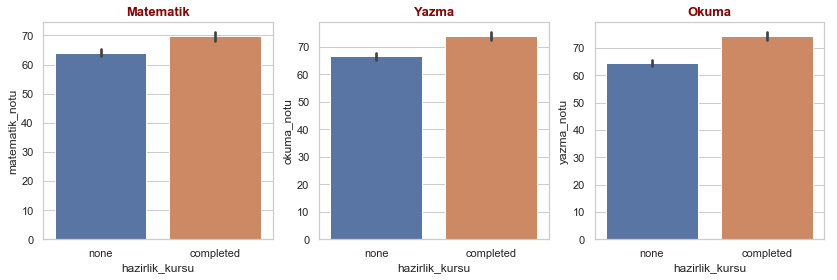

In [24]:
plt.figure(figsize = (14,4))
plt.subplot(1,3,1)
sns.barplot(df['hazirlik_kursu'], df['matematik_notu'])
plt.title('Matematik', fontdict = baslik_font)

plt.subplot(1,3,2)
sns.barplot(df['hazirlik_kursu'], df['okuma_notu'])
plt.title('Yazma', fontdict = baslik_font)

plt.subplot(1,3,3)
sns.barplot(df['hazirlik_kursu'], df['yazma_notu'])
plt.title('Okuma', fontdict = baslik_font)
plt.show()

Yukarıda, hazırlık kurslarını tamamlayan öğrencilerin bütün derslerde daha başarılı olduğunu görebiliriz. Şimdi matematik notları ve hazırlık kursu değişkenleri için T-testi yapalım.

In [27]:
#????
df_none = df[df['hazirlik_kursu'] == 'none']['matematik_notu']
df_completed = df[df['hazirlik_kursu'] == 'completed']['matematik_notu']

stats.ttest_ind(df_none, df_completed)

Ttest_indResult(statistic=-5.704616417349102, pvalue=1.5359134607147415e-08)

4. Korelasyonu en yüksek iki dersi bulalım

Aynı derslerin korelasyon katsayılarını sıfır yapalım.

In [140]:
daf = df.corr().values
np.fill_diagonal(daf, 0)

Matrisimizdeki en yüksek değerin pozisyonunu saptayalım.

In [119]:
a = np.where(daf == daf.max())
a
# [1,2]'de

(array([1, 2], dtype=int32), array([2, 1], dtype=int32))

In [141]:
df.corr()

,matematik_notu,okuma_notu,yazma_notu
matematik_notu,1.000,0.818,0.803
okuma_notu,0.818,1.000,0.955
yazma_notu,0.803,0.955,1.000


In [143]:
x= df.corr().columns[1]
y= df.corr().index.values[2]
print('Korelasyonu en yüksek olan iki ders: {} ve {} dur.'.format(x,y))

Korelasyonu en yüksek olan iki ders: okuma_notu ve yazma_notu dur.
